# Movie Recommendation System
Movie recommendation system using MovieLen 100K dataset. Comparison between Matrix Factorization, Non-negative Matrix Factorization, and Neural Network.

Code source from
https://nipunbatra.github.io/blog/2017/recommend-keras.html

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Read and Inspect Datasets

In [27]:
dataset = pd.read_csv("ml-100k/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))

In [28]:
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [29]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(943, 1682)

In [30]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [31]:
dataset.head()

,user_id,item_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


## Split training set and test set

In [32]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

## Recommendation using Matrix Factorization

In [33]:
import tensorflow as tf
import tensorflow.keras
from IPython.display import SVG
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

In [34]:
movie_input = tensorflow.keras.layers.Input(shape=[1],name='Item')
movie_embedding = tensorflow.keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = tensorflow.keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = tensorflow.keras.layers.Input(shape=[1],name='User')
user_vec = tensorflow.keras.layers.Flatten(name='FlattenUsers')(tensorflow.keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = tensorflow.keras.layers.dot([movie_vec, user_vec], axes=1, name='DotProduct')

model = tensorflow.keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [35]:
# SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [36]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
____________________________________________________________________________________________

In [37]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=1)

Train on 80000 samples
Epoch 1/100
80000/80000 [==============================] - 3s 36us/sample - loss: 12.0279
Epoch 2/100
80000/80000 [==============================] - 3s 34us/sample - loss: 4.5626
Epoch 3/100
80000/80000 [==============================] - 3s 34us/sample - loss: 1.9386
Epoch 4/100
80000/80000 [==============================] - 3s 34us/sample - loss: 1.3150
Epoch 5/100
80000/80000 [==============================] - 2s 26us/sample - loss: 1.0853
Epoch 6/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.9855
Epoch 7/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.93780s - loss: 0.937
Epoch 8/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.9127
Epoch 9/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.8978
Epoch 10/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.8884
Epoch 11/100
80000/80000 [==============================] - 2s 22us/s

80000/80000 [==============================] - 2s 22us/sample - loss: 0.7196
Epoch 90/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.7194
Epoch 91/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.7190
Epoch 92/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.7187
Epoch 93/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.7184
Epoch 94/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.7183
Epoch 95/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.7177
Epoch 96/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.7176
Epoch 97/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.7172
Epoch 98/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.7174
Epoch 99/100
80000/80000 [==============================] - 2s 22us/sample - loss: 0.7171
Epoch 100/100
80000/800

Text(0, 0.5, 'Train Error')

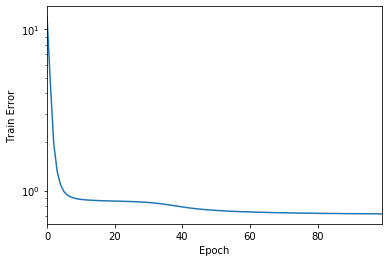

In [38]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [39]:
y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_true = test.rating

In [40]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.6946

In [41]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1683.000000,1683.000000,1683.000000
mean,0.975810,0.851396,0.937998
std,0.455443,0.518912,0.461832
min,-0.619111,-1.036764,-0.932491
25%,0.648488,0.502150,0.612579
50%,0.984188,0.852441,0.973312
75%,1.303464,1.236784,1.280570
max,2.542449,2.325980,2.482553


In [42]:
movie_embedding_learnt.shape

(1683, 3)

In [43]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,944.000000,944.000000,944.000000
mean,1.081534,1.187131,1.117269
std,0.513242,0.430761,0.547319
min,-1.242091,-0.749022,-0.606336
25%,0.768188,0.921875,0.745218
50%,1.093960,1.217144,1.106681
75%,1.421018,1.495152,1.491973
max,2.541045,2.396723,2.880352


In [44]:
user_embedding_learnt

array([[ 1.18353   ,  1.7226923 ,  0.5825984 ],
       [ 0.53640217,  1.8114469 ,  0.97647816],
       [ 0.97251827,  1.0810235 ,  0.6602126 ],
       ...,
       [ 1.058401  ,  1.0863191 ,  1.7012861 ],
       [ 1.5982289 ,  1.0798706 ,  0.7811139 ],
       [-0.01372885,  0.00786493, -0.04854197]], dtype=float32)

### Inspect the completed matrix

In [45]:
matrix = user_embedding_learnt.dot(np.transpose(movie_embedding_learnt))

In [46]:
matrix

array([[ 3.8766613e+00,  2.9156163e+00,  2.9493024e+00, ...,
         3.6652682e+00,  3.1490128e+00, -4.8320532e-02],
       [ 3.8951097e+00,  3.0158050e+00,  2.6182876e+00, ...,
         3.4959335e+00,  2.9952102e+00, -2.2179427e-02],
       [ 3.0459712e+00,  2.4333739e+00,  2.4123340e+00, ...,
         2.8661444e+00,  2.4286740e+00, -4.5698766e-02],
       ...,
       [ 4.5318980e+00,  3.9877856e+00,  3.5383682e+00, ...,
         4.0978942e+00,  3.3923197e+00, -6.5116011e-02],
       [ 3.7991962e+00,  3.1066375e+00,  3.2724216e+00, ...,
         3.6637015e+00,  3.0820866e+00, -7.7531345e-02],
       [-6.9191396e-02, -7.4924372e-02, -5.9450738e-02, ...,
        -5.9469610e-02, -4.5924492e-02,  1.4526668e-03]], dtype=float32)

## Recommendation using Deep Neural Network

In [49]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

In [51]:
movie_input = tensorflow.keras.layers.Input(shape=[1],name='Item')
movie_embedding = tensorflow.keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = tensorflow.keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = tensorflow.keras.layers.Dropout(0.2)(movie_vec)


user_input = tensorflow.keras.layers.Input(shape=[1],name='User')
user_vec = tensorflow.keras.layers.Flatten(name='FlattenUsers')(tensorflow.keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = tensorflow.keras.layers.Dropout(0.2)(user_vec)


concat = tensorflow.keras.layers.Concatenate(name='Concat')([movie_vec, user_vec])
concat_dropout = tensorflow.keras.layers.Dropout(0.2)(concat)
dense = tensorflow.keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = tensorflow.keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = tensorflow.keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = tensorflow.keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = tensorflow.keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = tensorflow.keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = tensorflow.keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = tensorflow.keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = tensorflow.keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

In [52]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         13464       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4720        User[0][0]                       
____________________________________________________________________________________________

In [53]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=1)

Train on 80000 samples
Epoch 1/100
80000/80000 [==============================] - 4s 54us/sample - loss: 0.8226
Epoch 2/100
80000/80000 [==============================] - 4s 48us/sample - loss: 0.7676
Epoch 3/100
80000/80000 [==============================] - 4s 48us/sample - loss: 0.7535
Epoch 4/100
80000/80000 [==============================] - 4s 48us/sample - loss: 0.7431
Epoch 5/100
80000/80000 [==============================] - 4s 48us/sample - loss: 0.7337
Epoch 6/100
80000/80000 [==============================] - 4s 48us/sample - loss: 0.7295
Epoch 7/100
80000/80000 [==============================] - 4s 48us/sample - loss: 0.7241
Epoch 8/100
80000/80000 [==============================] - 4s 48us/sample - loss: 0.7212
Epoch 9/100
80000/80000 [==============================] - 4s 48us/sample - loss: 0.7195
Epoch 10/100
80000/80000 [==============================] - 4s 49us/sample - loss: 0.7176
Epoch 11/100
80000/80000 [==============================] - 4s 48us/sample - loss: 0.7

80000/80000 [==============================] - 3s 32us/sample - loss: 0.6722
Epoch 90/100
80000/80000 [==============================] - 3s 32us/sample - loss: 0.6760
Epoch 91/100
80000/80000 [==============================] - 3s 32us/sample - loss: 0.6738
Epoch 92/100
80000/80000 [==============================] - 3s 32us/sample - loss: 0.6746
Epoch 93/100
80000/80000 [==============================] - 3s 32us/sample - loss: 0.6735
Epoch 94/100
80000/80000 [==============================] - 3s 32us/sample - loss: 0.6718
Epoch 95/100
80000/80000 [==============================] - 3s 32us/sample - loss: 0.6718
Epoch 96/100
80000/80000 [==============================] - 3s 32us/sample - loss: 0.6741
Epoch 97/100
80000/80000 [==============================] - 3s 32us/sample - loss: 0.6738
Epoch 98/100
80000/80000 [==============================] - 3s 32us/sample - loss: 0.6715
Epoch 99/100
80000/80000 [==============================] - 3s 32us/sample - loss: 0.6736
Epoch 100/100
80000/800

In [54]:
y_hat_2 = np.round(model.predict([test.user_id, test.item_id]),0)
print(mean_absolute_error(y_true, y_hat_2))

0.6964
